Author: Muhammad Ammad-ud-din

Place: Helsinki, Finland

# Predictive Technqiues: goals and challenges

Classification is a machine learning problem where the goal is to learn a discriminative model (function and its parameters) in a supervised setting: Given a set of samples having multi-dimensional features, for which outcome measurements exist, predict the outcome for a new sample. The development of robust and efficient predictve techniques is a two-fold data science approach: (1) data exploration, (2) machine learning model selection and evaluation.

As a first step, exploratory analysis of the data is essential to gain insights into the problem as well as into the data and to identify the underlying modeling challenges. Moreover, data exploration also helps to formulate the appropriate modeling assumptions and experimental design while considering the resources at hand. As a second step, selection of the optimal model is crucial such that it generalizes to the new data. The optimal model can be selected based on the performance metric obtained through rigorous evaluation of the modeling assumptions with a principled experimental design.   

In [1]:
#including packages and modules that will be needed 
import itertools
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randuni


from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler, QuantileTransformer, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import auc, roc_curve, confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler,
                                     NearMiss,
                                     InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection,
                                     TomekLinks)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

#print(__doc__)

sns.set_style('white')
%matplotlib inline

RANDOM_STATE = 101

In [2]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append(cs[i])
                    break

    return dups

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
    cm = np.round(cm,0)
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'#'d'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Exploratory Analysis of the Data

Understanding data through exploration is the key to many data science problems. Exploration helps to develop hypothesis on the data generation process and to formulate approriate assumptions for the modelling task. In this realm, 
1. I start looking at the data dimensionalities and found that the data contains 124494 samples and 9 features, 1 target/output column and 2 meta data features namely date and device. 
2. Since there are very few features, the visual inspection already showed that the data ranges quite different. Some features have values in very high range while other features have values in lower ranges. NB: need some standardization!
3. I computed the class frequencies and found the there are 124388 samples in one class whereas only 106 sample in the other class. NB: handle class imbalance scenario!
4. I explored the distribution of features across the two classes to hints on features which can discriminate samples into the 2 classes. 
5. To understand the structure or potential relationhsips that exist in the data, I looked at the PCA projections in two dimensions. 

NB: in practice all the data exploration should be done on training data only, however, for the sake of this assignment I am willing to welcome some over-fitting :D  

In [3]:
#read csv file into pandas dataframe
raw_data = pd.read_csv('device_failure.csv')
#investigating null or na values
print(raw_data.isnull().sum())
raw_data = raw_data.dropna(axis=0)
print(raw_data.head(5))
print(raw_data.shape)

date          0
device        0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
failure       0
dtype: int64
    date    device  attribute1  attribute2  attribute3  attribute4  \
0  15001  S1F01085   215630672          56           0          52   
1  15001  S1F0166B    61370680           0           3           0   
2  15001  S1F01E6Y   173295968           0           0           0   
3  15001  S1F01JE0    79694024           0           0           0   
4  15001  S1F01R2B   135970480           0           0           0   

   attribute5  attribute6  attribute7  attribute8  attribute9  failure  
0           6      407438           0           0           7        0  
1           6      403174           0           0           0        0  
2          12      237394           0           0           0        0  
3           6      410186           0           0           0        0  
4        

In [4]:
#seems like there is a duplicate column, lets drop it.
raw_data.drop(duplicate_columns(raw_data),axis=1,inplace=True)
features = ['attribute1','attribute2','attribute3','attribute4',
                                'attribute5','attribute6','attribute8','attribute9']
print(raw_data.head(5))

    date    device  attribute1  attribute2  attribute3  attribute4  \
0  15001  S1F01085   215630672          56           0          52   
1  15001  S1F0166B    61370680           0           3           0   
2  15001  S1F01E6Y   173295968           0           0           0   
3  15001  S1F01JE0    79694024           0           0           0   
4  15001  S1F01R2B   135970480           0           0           0   

   attribute5  attribute6  attribute8  attribute9  failure  
0           6      407438           0           7        0  
1           6      403174           0           0        0  
2          12      237394           0           0        0  
3           6      410186           0           0        0  
4          15      313173           0           3        0  


        Status   Count
0  Not Failure  124388
1      Failure     106


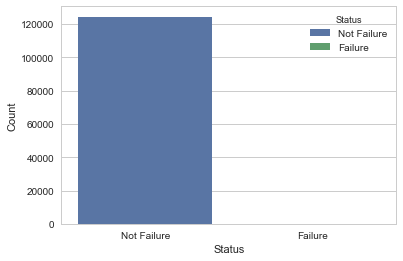

In [5]:
########get the sample count based on failure vs non-failure status
stats =raw_data['failure'].value_counts()
stats = stats.to_frame()
stats.reset_index(inplace=True)

stats.rename(columns={'index':'Status','failure':'Count'}, inplace=True)
stats.replace(0,'Not Failure', inplace=True)
stats.replace(1,'Failure', inplace=True)
print(stats)

sns.set(style="whitegrid")
sns.barplot(x="Status",y="Count",hue="Status",data=stats,
               dodge=False)

plt.show()

The above figure and stats clearly demonstrate that this is an inherit class imbalance problem.

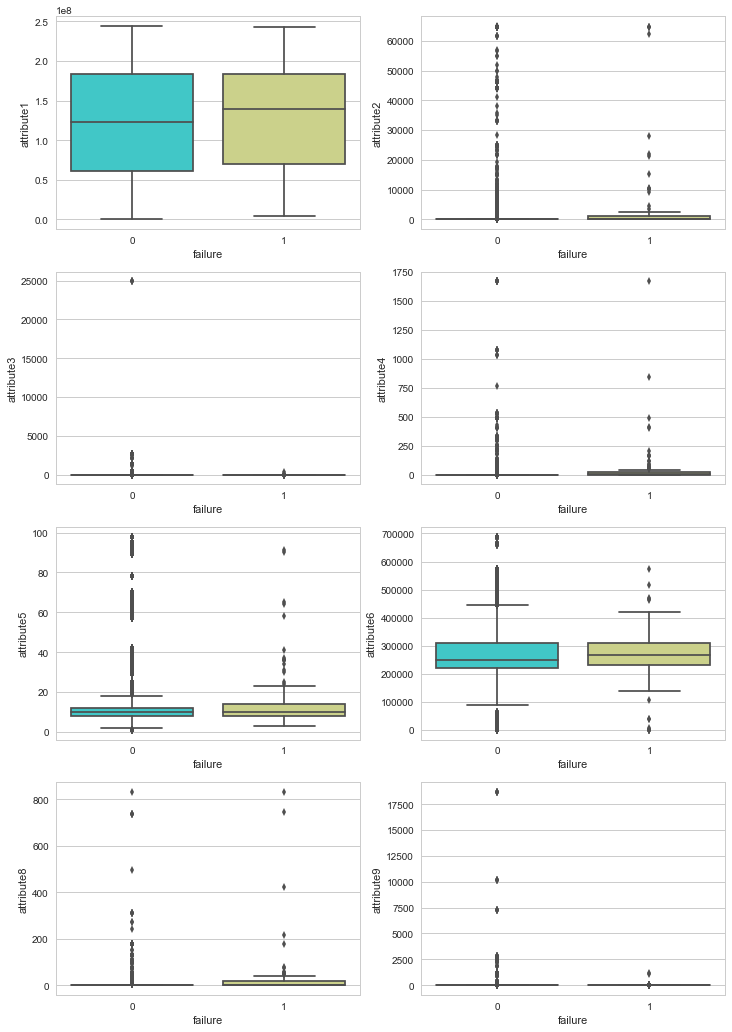

In [6]:
#lets investigate the distribution of features across the two classes.
#ploting feature data (shown in y-axis) for the samples in two classes (shown in x-axis)
sns.set(style="whitegrid")
fig, axes = plt.subplots(4,2, figsize=(12,18))
sns.boxplot(x="failure", y='attribute1', data=raw_data,palette='rainbow', ax=axes[0,0])
sns.boxplot(x="failure",  y='attribute2', data=raw_data,palette='rainbow', ax=axes[0,1])
sns.boxplot(x="failure", y='attribute3', data=raw_data,palette='rainbow', ax=axes[1,0])
sns.boxplot(x="failure",  y='attribute4', data=raw_data,palette='rainbow', ax=axes[1,1])
sns.boxplot(x="failure", y='attribute5', data=raw_data,palette='rainbow', ax=axes[2,0])
sns.boxplot(x="failure",  y='attribute6', data=raw_data,palette='rainbow', ax=axes[2,1])
sns.boxplot(x="failure", y='attribute8', data=raw_data,palette='rainbow', ax=axes[3,0])
sns.boxplot(x="failure",  y='attribute9', data=raw_data,palette='rainbow', ax=axes[3,1])
plt.show()

Few observations from the above figures: 
1. There are outliers (noisy samples) in the data. Generally there are two types of variations in the data:(a) that corresponds to interesting variations (aka true signal) and that we would want to learn through modelling, (b) that corresponds to outliers (technical variations or sample-specific) that we would want to get rid of. Offcourse, the definition of interesting and technical variations vary from problem to problem. Here, the technical variations within one class are demmed in the samples which are very far away from the mean of the distribution. 
2. Attribute1, Attribute5 and Attribute6 are informative or important features. Their values are different for the two classes which mean these can help to learn a discriminative model. The goal of a machine learning model would then be to learn the importances of these features in a data-driven manner.  

In [7]:
#lets bring the raw data into the format usable by the machine learning models
X = np.array(raw_data[features])
y = np.array(raw_data['failure'])

#print(X.shape)
#print(y.shape) 

#split the data into train and test set
#training data will be used for model selection,  
np.random.seed(RANDOM_STATE)
xTrain, xTest, yTrain, yTest = train_test_split(X, y, random_state=RANDOM_STATE)


#computing feature-wise mean of the data
mTrain = np.mean(xTrain,axis=0)
#print('Training Data feature-wise mean : {}'.format(mTrain))

#computing feature-wise standard deviation of the data
sdTrain = np.std(xTrain,axis=0)
sdTrain[sdTrain==0]=1
#print('Training Data feature-wise sd : {}'.format(sdTrain))

#standardizing the data to have mean=0, std=1 (aprior assuming all features are equally important)
nXtrain = (xTrain - mTrain) / sdTrain
nXtest = (xTest - mTrain) / sdTrain

#print(xTrain[0:3,0:3])
#print(nXtrain[0:3,0:3])

#print(xTest[0:3,0:3])
#print(nXtest[0:3,0:3])

#print('Training X statistics: {}'.format(nXtrain.shape))
#print('Testing X statistics: {}'.format(nXtrain.shape))
#print('Training y statistics: {}'.format(Counter(yTrain)))
#print('Testing y statistics: {}'.format(Counter(yTest)))



Principal Component Analysis (PCA) is a matrix factorization approach that decomposes the observed data into multiple low-dimensional latent factors (also known as "components"). The underlying assumption is that the combination of multiple latent factors has generated the data, corrupted with some noise. However, each combination has generated some parts of the data. The machine learning aim is then to learn these components thereby capturing the strongest variation patterns for individual features in a principled way. In this way, the latent factors can then be seen as
low-dimensional representation that has actually generated the observed data. Studying the latent reprsentation can help reveal useful patterns hidden in the data.

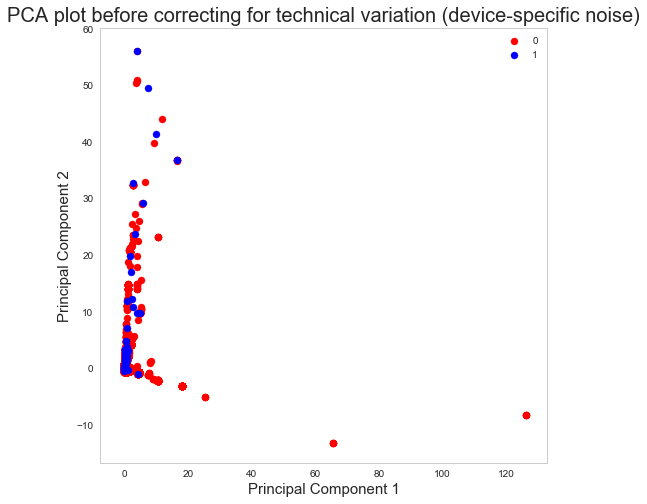

In [8]:
# PCA analysis of the data to reveal hidden structure of the data
# Make an instance of the Model
pca = PCA(n_components = 2)
pca.fit(nXtrain)
xPCA = pca.transform(nXtrain)

principalDf = pd.DataFrame(data = xPCA
            , columns = ['principal component 1', 'principal component 2'])
target = pd.DataFrame(yTrain)
finalDf = pd.concat([principalDf, target], axis = 1)
finalDf.rename(columns={0: 'target'}, inplace=True)
#print('PCA plot before correcting for technical variation (noise) i.e., device specific')


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA plot before correcting for technical variation (device-specific noise)', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Again some key observations from the above figure: 
1. Some samples (noisy) are extremely far away forcing the overall data to squeeze around zero. 
2. The data are not linearly separable. The patterns demonstrate complex relationships/structure among the data samples.  

# What are the modeling challenges(?):
In the proposed problem, exploratory analysis of the data identifies three fundamental modeling challenges: 
1. extremely noisy observation, perhaps due to the technical variations and outliers
2. imbalanced class frequencies,
3. complex non-linear structure.

Class imbalances are an inherent characteristic of many real-world machine learning problems and require particular attention while developing models. Likewise, in this data, the proportion of majority class (not-failure) is  $\sim$99%, and the minority class (minority) is  $\sim$1%. On the other hand, increasing noisy obervations from the devices poses difficulties inferring model and parameters correctly. Furthermore, the analysis also reveals non-linear structure from the data meaning that the two classes are not linearly separable, in the original space.


# What is my solution(?):
 To solve the challenges mentioned above, my solution combines three machine learning principles:
 1. normalization and standardization, 
 2. sub-sampling to account for class imbalances,
 3. non-linear classification models.
 
 
## Normalization and Standardization
I applied the "limma" model. Limma is a linear model that tries to estimate, for each sample, the true signal by removing the signal due to the technical effects. Here a sample denotes a device and limma is used to normalize the data of each device that span across multiple dates. Essentially this would corresponds to removing device-specfic variation and retaining the true signal about its failure/not failure. Limma was run in R computing language (code shown below) since its handy implmentation is available there. 


source("https://bioconductor.org/biocLite.R")

biocLite("limma")

library(limma)

data = read.csv('device_failure.csv',header = T)

deviceIDs = data$device

failures = data$failure

timesStamps = data$date

featuresLabels = c('attribute1','attribute2','attribute3','attribute4',
            'attribute5','attribute6','attribute8','attribute9')

features = data[,featuresLabels]

rm(data)

data.batch	<- removeBatchEffect(t(features), batch=deviceIDs)

data = cbind(timesStamps,as.character(deviceIDs),t(data.batch),as.vector(failures))

colnames(data) = c('date','device',featuresLabels,'failure')

write.csv(data, file = 'device_corrected_failure.csv',quote = FALSE)

To balance the feature-wise scales, z-transformation was performed. After this standardization  each features has mean=0 and standard deviation=1 meaning all features have equal scales/ranges. In other words, while doing this standardization I aprior assume that all features are equally important. Though the data exploration steps revealed potential relevant features, I intended to adopt a purely data-driven approach and letting the models choose the best features. On the contrary, datasets/problems comprising of a large number of features and very small sample sizes, I would make use of the data exploration results and any prior knowledge (available from the expert) to be included in the model in a more systematic way.


## Sub-sampling
To tackle class imbalances, I chose a "down"  sampling approach. Mainly, this type of sampling randomly picks subset of samples from the majority class to match the sample size of the minority class. In the current set-up, this choice is plausible since there are available much more samples from a majority class and picking their subsets at random would not only reduce the noise but also favor learning a balanced classifier.

## Non-linear classification models
From the modeling perspective, linear models are a natural choice, since they are interpretable, easy-to-understand and provide direct information on the relationship between the features and outcome. However, they neglect the relevant non-linear structure in the data. As a result, the nonlinear-models provide better predictions by modeling complex interactions, of course, compromising the interpretability. As the primary focus of the problem is purely a prediction task (no interpretability is desired), I resort using the state-of-the-art non-linear machine learning models.   

In [9]:
#read device effect corrected data from csv file into pandas dataframe
#investigating null or na values
raw_data = pd.read_csv('device_corrected_failure.csv')
#investigating null or na values
print(raw_data.isnull().sum())
raw_data = raw_data.dropna(axis=0)
print(raw_data.head(5))
print(raw_data.shape)

Unnamed: 0    0
date          0
device        0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute8    0
attribute9    0
failure       0
dtype: int64
   Unnamed: 0   date    device    attribute1  attribute2  attribute3  \
0           1  15001  S1F01085  2.228744e+08  501.830716   29.325347   
1           2  15001  S1F0166B  7.705158e+07  501.830715   29.325346   
2           3  15001  S1F01E6Y  1.633600e+08  501.830716   29.325346   
3           4  15001  S1F01JE0  3.557060e+07  501.830716   29.325346   
4           5  15001  S1F01R2B  1.428706e+08  501.830716   29.325346   

   attribute4  attribute5     attribute6  attribute8  attribute9  failure  
0    5.760627   12.214346  255395.780309    1.001178   49.191531        0  
1    5.760627   12.214346  255461.113620    1.001178   49.191531        0  
2    5.760627   12.214346  238303.676140    1.001178   49.191531        0  
3    5.760627   12.214346  255391.446969    1.001178   49.

After correcting for technical variation (device-specific noise)


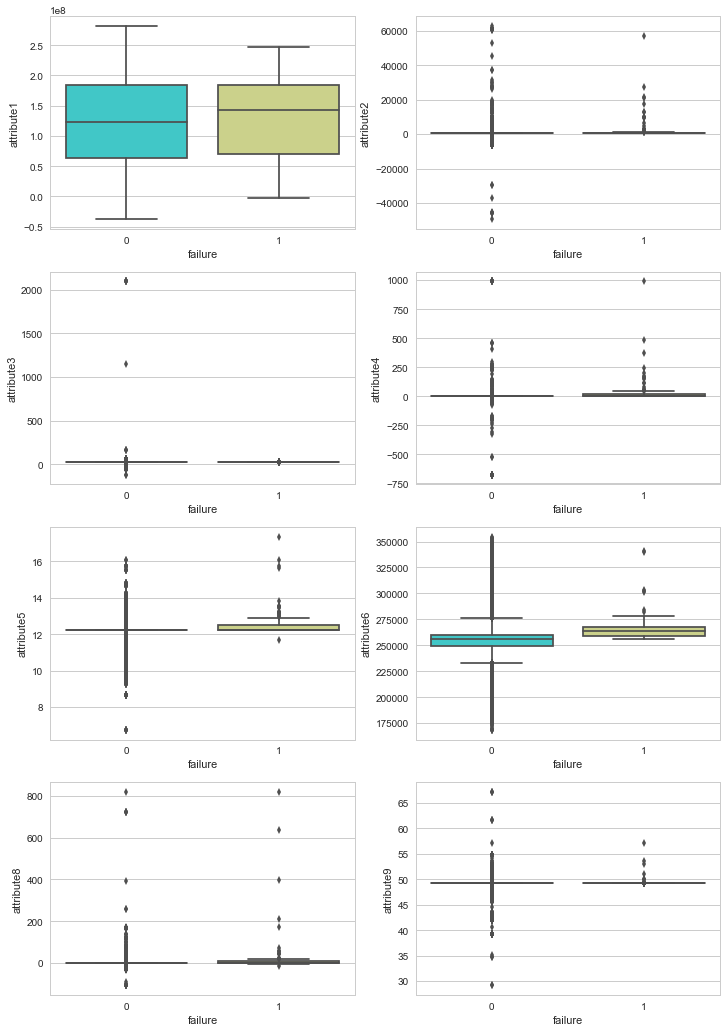

In [10]:
print('After correcting for technical variation (device-specific noise)')
sns.set(style="whitegrid")
#plt.figure(figsize=(10,46))

fig, axes = plt.subplots(4,2, figsize=(12,18))
sns.boxplot(x="failure", y='attribute1', data=raw_data,palette='rainbow', ax=axes[0,0])
sns.boxplot(x="failure",  y='attribute2', data=raw_data,palette='rainbow', ax=axes[0,1])
sns.boxplot(x="failure", y='attribute3', data=raw_data,palette='rainbow', ax=axes[1,0])
sns.boxplot(x="failure",  y='attribute4', data=raw_data,palette='rainbow', ax=axes[1,1])
sns.boxplot(x="failure", y='attribute5', data=raw_data,palette='rainbow', ax=axes[2,0])
sns.boxplot(x="failure",  y='attribute6', data=raw_data,palette='rainbow', ax=axes[2,1])
sns.boxplot(x="failure", y='attribute8', data=raw_data,palette='rainbow', ax=axes[3,0])
sns.boxplot(x="failure",  y='attribute9', data=raw_data,palette='rainbow', ax=axes[3,1])
plt.show()

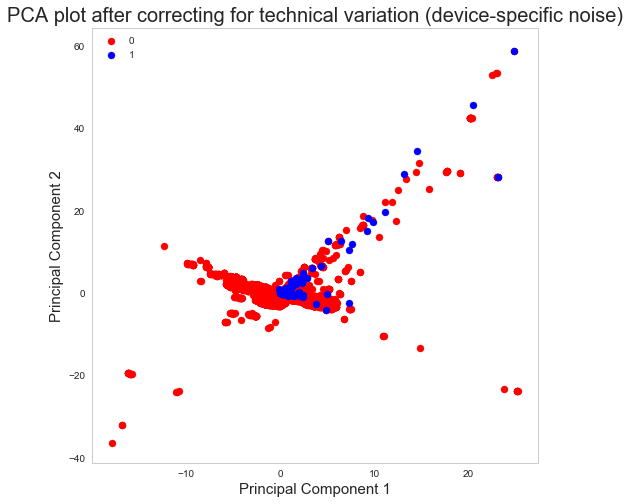

In [11]:
#lets bring the raw data into the format usable by the machine learning models
X = np.array(raw_data[features])
y = np.array(raw_data['failure'])

#print(X.shape)
#print(y.shape) 

#split the data into train and test set
#training data will be used for model selection,  
np.random.seed(RANDOM_STATE)
xTrain, xTest, yTrain, yTest = train_test_split(X, y, random_state=RANDOM_STATE)


#computing feature-wise mean of the data
mTrain = np.mean(xTrain,axis=0)
#print('Training Data feature-wise mean : {}'.format(mTrain))

#computing feature-wise standard deviation of the data
sdTrain = np.std(xTrain,axis=0)
sdTrain[sdTrain==0]=1
#print('Training Data feature-wise sd : {}'.format(sdTrain))

#standardizing the data to have mean=0, std=1 (aprior assuming all features are equally important)
nXtrain = (xTrain - mTrain) / sdTrain
nXtest = (xTest - mTrain) / sdTrain

#print(xTrain[0:3,0:3])
#print(nXtrain[0:3,0:3])

#print(xTest[0:3,0:3])
#print(nXtest[0:3,0:3])

#print('Training X statistics: {}'.format(nXtrain.shape))
#print('Testing X statistics: {}'.format(nXtrain.shape))
#print('Training y statistics: {}'.format(Counter(yTrain)))
#print('Testing y statistics: {}'.format(Counter(yTest)))


# PCA analysis of the data to reveal hidden structure of the data
# Make an instance of the Model
pca = PCA(n_components = 2)
pca.fit(nXtrain)
xPCA = pca.transform(nXtrain)

principalDf = pd.DataFrame(data = xPCA
            , columns = ['principal component 1', 'principal component 2'])
target = pd.DataFrame(yTrain)
finalDf = pd.concat([principalDf, target], axis = 1)
finalDf.rename(columns={0: 'target'}, inplace=True)
#print('PCA plot before correcting for technical variation (noise) i.e., device specific')


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA plot after correcting for technical variation (device-specific noise)', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Few observations from the figures above, boxplots and PCA plot:
1. The boxplots look fine after the normalization, though it seems that some outliers are still existing. Attribute1, Attribute5 and Attribute6 still seen as informative, validating that we have not lost the true signal. 
2. PCA plot is now centered around zero, with two classes being stacked on top of each other. Again demostrating non-linear and complex relationships. Probably some non-linear dimensionality reduction approach, for instance Kernel PCA can better help to visualize the disjoint clusters.

# How did I implement the solution(?):

Since my knowledge about the given problem was limited, therefore it was difficult to formulate the correct assumptions to model non-linear or complex relationships. I, therefore, compared various machine learning models and chose the model that provided best classification performance and is better generalizable.  To put into context, I evaluated Random Forest (RF), Gradient Boosting (GB), Support Vector Machines (SVC with Guassian/RBF kernel) and a state-of-the-art non-parameteric K-Nearest Neighbor (KNN) models on the task of classifying new samples into two classes. 
	
As an experiment design process, I partitioned the given labeled data into training (67\%) and  held-out test set (33\%), randomly. Since data exploration already revealed class imbalances, I created stratified 5 folds of the training data, such that the ratios of majority vs. minority classes were kept consistent across all the folds. The held-out test data had the same consistency of the class distributions as observed from the labeled data. In case of class imbalances, stratified K-folds is central to the experimental design since it can significantly help to avoid overfitting on the training data. 
	
As a model selection procedure, I performed 5-fold cross-validation (CV) on the training data, wherein each fold of the CV run, 1/5th of the data was used as a validation set at random, while the model was trained on the other 4/5 data. Since each model has specific parameters to be tuned (aka Hyperparameters), a nested Randomized CV approach was adopted for that purpose. 

And, for each modeling approach, predictive performances were avraged across the validation set  predictions obtained from a each round of CV experiment. Mainly, the ROC-AUC performance metric that is important to estimate the effect of class imbalances (taking into account true positive, false postive, false negative and true negative rates), is used to evaluate the efficient model. 

In simple words, training data was used to tune the hyperparameters and validation data was utilized to assess the predictive performance and to select the best model. The test set predictions were generated using the best model.


## Hyperparameter Tuning and Model Selection:
In a machine learning model, hyperparameters represents the our prior beliefs about the model structure and the underlying data generation process. Since we have little knowledge about the real-world process and the degree of noise that has corrupted the data, it is difficult to fix suitable hyperparameters apriori. We have to resort to optimization methods to supplement our beliefs on the potentially appropriate choices of the hyperparameters. The performance and generalisation properties of model is very dependent on values chosen for the hyper-parameters. As the number of hyper-parameters and the number of values they can have increases the more complex the hyper-parameter optimisation problem becomes. 

Grid Search, a typical approach to hyper-parameter tuning is to build the ML model in question, over all the data for different combination of hyper-parameters. So for 2 hyper-parameters, the first with 3 possible values and the second with 5 then a total of 15 models would need to be built and tested to find the optimal hyper-parameter configuration. If each hyper-parameter had 10 possible values then 100 comparisons would be required. It is easily seen the number of possible hyper-parameter configurations increases exponentially with the number of hyper-parameters and the number of values they can have. 

On the contrary, a randomised search approach to hyper-parameter tuning is known to be more efficient than a grid-search in terms of computational time. Randomised search means searches are not wasted on parts of the hyper-parameter grid which have little influence on the performance of the model based on the low effective dimension of the hyper-parameter space. Thus, I chose RandomizedSearchCV as a hyperparamter tuning and model selection procedure.  


In [12]:
#define hyperparamters and CV configurations
nFolds = 5
randomIterations = 25
cv = StratifiedKFold(n_splits=nFolds)


param_grid = {'SVC':{"C": sp_randint(1, 1e5),
                     "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1,0.5,1.0],
                     "kernel": ['rbf']},
              'RF': {"n_estimators": sp_randint(100, 500),
                     "max_depth": sp_randint(3, 15),
                     "max_features": sp_randint(2, 3),
                     "min_samples_split": sp_randint(2, 3),
                     "min_samples_leaf": sp_randint(1, 3)},
             'KNN':{"n_neighbors":sp_randint(2, 50),
                   "algorithm":["ball_tree","kd_tree","brute","auto"],
                   "p":[1,2]},
             'GB': {"loss":["deviance","exponential"],
                    "n_estimators": sp_randint(100, 500),
                    "max_depth": sp_randint(3, 15),
                    "max_features": ["auto","sqrt","log2",None],
                    "min_samples_split": sp_randint(2, 3),
                    "min_samples_leaf": sp_randint(2, 3),
                    "learning_rate":[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5]}
             }
#set RandomizedCV approach for the model selection and hyperparameter tuning
classifiers = ['RF', RandomizedSearchCV(estimator=RandomForestClassifier(class_weight="balanced_subsample", oob_score=True,random_state=RANDOM_STATE), 
                                        param_distributions=param_grid['RF'],n_iter=randomIterations,cv=nFolds,scoring='roc_auc'),
               'GB', RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=RANDOM_STATE), 
                                        param_distributions=param_grid['GB'],n_iter=randomIterations,cv=nFolds,scoring='roc_auc'),
               'SVC', RandomizedSearchCV(SVC(probability=True,random_state=RANDOM_STATE,class_weight='balanced'), #class_weight='balanced',
                                        param_distributions=param_grid['SVC'],n_iter=randomIterations,cv=nFolds,scoring='roc_auc'),
               'KNN', RandomizedSearchCV(KNeighborsClassifier(weights='distance'), 
                                        param_distributions=param_grid['KNN'],n_iter=randomIterations,cv=nFolds,scoring='roc_auc')]

#choose sub-sampling strategy
sampler = ['RUS', RandomUnderSampler(random_state=RANDOM_STATE,replacement=True)]


#make model evaluation pipelines
pipelines = [
    ['{}-{}'.format(sampler[0], classifiers[0]),
     make_pipeline(sampler[1], classifiers[1])], #RF
    ['{}-{}'.format(sampler[0], classifiers[2]),
     make_pipeline(sampler[1], classifiers[3])], #GB
    ['{}-{}'.format(sampler[0], classifiers[4]), 
     make_pipeline(sampler[1], classifiers[5])], #SVC
    ['{}-{}'.format(sampler[0], classifiers[6]), 
     make_pipeline(sampler[1], classifiers[7])], #KNN
]

Evaluating Machine Learning Models on Validation Set
{Sampling}-{Model} RUS-RF
{Sampling}-{Model} RUS-GB
{Sampling}-{Model} RUS-SVC
{Sampling}-{Model} RUS-KNN


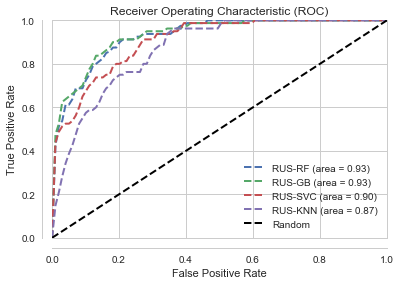

In [13]:
#Run model pipelines and draw evaluation metrics
lw=2
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
print("Evaluating Machine Learning Models on Validation Set")

for name, pipeline in pipelines:
    print("{Sampling}-{Model}", name)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(nXtrain, yTrain):
        probas_ = pipeline.fit(nXtrain[train], yTrain[train]).predict_proba(nXtrain[test])
        fpr, tpr, thresholds = roc_curve(yTrain[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= cv.get_n_splits(nXtrain, yTrain)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, linestyle='--',
             label='{} (area = %0.2f)'.format(name) % mean_auc, lw=lw)

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Random')

# make ROC-AUC plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')

plt.legend(loc="lower right")

plt.show()

In [14]:
#selecting RF to generate predictions on test set (held-out)
name= pipelines[0][0] 
pipeline = pipelines[0][1]
print("{Down Sampling}-{Model} : ", name)
model = pipeline.fit(nXtrain, yTrain)
yProb = model.predict_proba(nXtest)
yPred = model.predict(nXtest)
fpr, tpr, thresholds = roc_curve(yTest, yProb[:, 1])
roc_auc = auc(fpr, tpr)


{Down Sampling}-{Model} :  RUS-RF


In [15]:
print('{} (area = %0.2f)'.format(name) % roc_auc)

RUS-RF (area = 0.95)


In [16]:
print(classification_report_imbalanced(yTest, yPred))
c_mat = confusion_matrix(yTest, yPred)

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.86      0.88      0.93      0.07      0.01     31098
          1       0.01      0.88      0.86      0.01      0.07      0.00        26

avg / total       1.00      0.86      0.88      0.93      0.07      0.01     31124



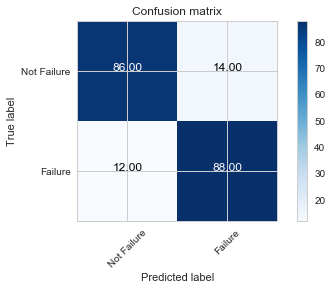

In [17]:
plot_confusion_matrix(c_mat, classes=['Not Failure', 'Failure'],
                      title='Confusion matrix')

# How good is the solution(?):
The ROC plot shows the true positive rate (on y -axis) vs. false postive rate (on axis) of predicted labels, averged over the validation sets for each of the methods. The closer the curve to 1 (on y-axis), the better is the model. The RF, GB, and SVC provided improved classifications than KNN, validating the non-linear modeling assumptions. KNN is slightly worse than the other three models. But the difference is quite small and may not be statistically significant. Since, the random forest and gradient boosting are ensemble based learning approach and is expected to maintain a reasonable tradeoff between the bias and variance, thus better generalizable to new data, as compared to KNN. I chose random forest for learning the model of complete labeled training data and generated predictions for the test set. Where, the model gave an ROC-AUC (area) of 0.95 when tested with random forest, thereby validating the proposed solution. Other important evaluation metric is recall for the two classes: 0.86 and 0.88.

But the important question is what does this performance metrics imply in practice. To find answer lets look into the confusion matrix shown above (row-wise normalized to show percentages). For the majority class (Not Failure), 86% of the devices have been correctly classified, where as only 14% have been miss-classified as falied. Likewise, for the minority class, 88% of the devices have been correctly classified as failed, while only 12% have been miss-classified as not falied.    

Now, let's assume this solution has been operationalized as an AI assistant to detect device failure. In this case, the falied devices are denoted by the minority class. Naturally, the goal here would be to detect the failed devices with higher accuracy as much as possible. In other words, the optimal solution should minimize the error on the minority class. The results demonstrate that 88% of the devices will be classified correctly by my solution, while minimal resources (man-power, time and cost) would be required for only 12% of the devices to manually inspect and evaluate failures. On the contrary, miss-classifying 14% of the "not failed devices" as "failed" will be initially quarantined for inspection and later-on these will be cleared without increasing any overhead on resources. 


# How can the solution be improved (?):

If there are available more resources (regarding time and computing power) then perhaps I would get estimates of performances from the 5-fold cross-validation procedure that is repeated multiple times with different random cross-validation stratified folds. 
Also to minimize over-fitting at the zero-ish level, I will adopt the nested CV so that the normalization/standardization is done separately for each of the nested folds too. Any preprocessing/feature engineeering that is solely done on training data is crucial to avoid over-fitting that could be caused by the leakage of test data into the training phase (also known as double-dipping). 

There exist various other sampling approaches such as "up", "smote" and "rose" to tackle class imbalances, it is worth testing them. Non-linear dimensionality reduction techniques, for instance, Kernel PCA could be explored when non-linearities are inherent in the data. Moreover, a bunch of probabilistic machine learning models can also be tested, as the Bayesian approach offers systematic solutions to handle uncertainties in the data that arise due to the noisy observations, in addition to providing confidence intervals on the classification estimates. Lastly, a new machine learning model or customized solution (tailor-made AI assistant for device failure) can be further developed, given detailed knowledge about the data, the problem and operational use case.

A alternative part of the solution which is untouched, perhaps due to the modelling assumptions I took at the first place, which involve solving this problem with approach that do not model the temporal behaviour of the devices. A relatively conservative assumption here is that each date and device entry is an independent sample and the aim is to learn a discriminative model of the full data such that when a new sample (encoded by the device and date) is observed, the model is able to predict label for it.  

Since date is also available as part of meta-data, the solution can certainly be improved if temporal behaviour of the devices is incorporated into the models. That would require heavy engineering to design and built features that exhibit the temporal patterns. That would also demand more data is available, especially for the missing part and particularly the post-maintenance data when the device has already been repaired. 
With these type of data if available, it is possible to formulate the problem as a sequence prediction rather than conventional classification, and with recent advances in deep learning frameworks it will be plausible to predict whether the device will fail in near future, thus providing better scheduling of the maintenance with minimal resources and predictive techniques. 